# MIScnn: Kidney Tumor Segmentation Challenge 2019

We want to perform a 3-fold cross-validation for kidney tumor segmentation on the Kidney Tumor Segmentation Challenge 2019 (KITS19) data set. To archieve this, we are using our newly developed framework for medical image segmentation. MIScnn: A Framework for Medical Image Segmentation with Convolutional Neural Networks and Deep Learning.

The aim of MIScnn is to provide an intuitive API allowing fast building of medical
image segmentation pipelines including data I/O, preprocessing, data augmentation, patch-wise analysis, metrics, a library with state-of-the-art
deep learning models and model utilization like training, prediction as well as fully automatic evaluation (e.g. cross-validation).
Even so, high configurability and multiple open interfaces allow full pipeline customization. MIScnn is based on Keras with Tensorflow as backend.

More information about MIScnn can be found in the publication or on the Git repository: https://github.com/frankkramer-lab/MIScnn

The task of the KITS19 challenge was to compute a semantic segmentation of arterial phase abdominal CT scans from 300 kidney cancer patients. Each pixel had to be labeled into one of three classes: Background, kidney or tumor. The original scans have an image resolution of 512x512 and on average 216 slices (highest slice number is 1059).

The data for the KITS19 challenge can be found here: https://github.com/neheller/kits19

## Tensorflow Configurations

Before using the MIScnn pipeline, we throttle the Tensorflow Memory hunger by using the RAM growth option.  
This result into a dyanmic growth of required RAM instead of allocating all available RAM without even using it.

Also, we are specify on which GPU Tensorflow should be executed.  
Obviously, we can skip this paragraph if don't need to share you GPUs with other people ;)

In [1]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

## Create a Data I/O class for the KITS19 files

The first step in the MIScnn pipeline is to establish a Data I/O. MIScnn offers the utilization of custom Data I/O interfaces for fast integration of your specific data structure into the pipeline.   
The KITS19 CT scans are encoded in NIfTI format, therefore we are going to deploy a Data I/O class with the NIfTI interface for handling the NIfTI format.

In [2]:
# Library import
from miscnn.data_loading.interfaces.nifti_io \
     import NIFTI_interface
from miscnn.data_loading.data_io import Data_IO

# Initialize the NIfTI I/O interface and configure the images as one channel (grayscale) and three segmentation classes (background, kidney, tumor)
interface = NIFTI_interface(pattern="case_00[0-9]*", 
                            channels=1, classes=3)

# Specify the kits19 data directory ('kits19/data' was renamed to 'kits19/data.original')
data_path = "../kits19/data.original/"
# Create the Data I/O object 
data_io = Data_IO(interface, data_path)

Now, let's test how many samples we can access through our Data I/O Interface.  
We are trying to print out all accessible sample ID's.

In [3]:
sample_list = data_io.get_indiceslist()
sample_list.sort()
print("All samples: " + str(sample_list))

All samples: ['case_00000', 'case_00001', 'case_00002', 'case_00003', 'case_00004', 'case_00005', 'case_00006', 'case_00007', 'case_00008', 'case_00009', 'case_00010', 'case_00011', 'case_00012', 'case_00013', 'case_00014', 'case_00015', 'case_00016', 'case_00017', 'case_00018', 'case_00019', 'case_00020', 'case_00021', 'case_00022', 'case_00023', 'case_00024', 'case_00025', 'case_00026', 'case_00027', 'case_00028', 'case_00029', 'case_00030', 'case_00031', 'case_00032', 'case_00033', 'case_00034', 'case_00035', 'case_00036', 'case_00037', 'case_00038', 'case_00039', 'case_00040', 'case_00041', 'case_00042', 'case_00043', 'case_00044', 'case_00045', 'case_00046', 'case_00047', 'case_00048', 'case_00049', 'case_00050', 'case_00051', 'case_00052', 'case_00053', 'case_00054', 'case_00055', 'case_00056', 'case_00057', 'case_00058', 'case_00059', 'case_00060', 'case_00061', 'case_00062', 'case_00063', 'case_00064', 'case_00065', 'case_00066', 'case_00067', 'case_00068', 'case_00069', 'case_

## Create and configure a Data Augmentation class

After the Data I/O Interface initialization, the Data Augmentation class can be configured.  
A Preprocessor object with default parameters automatically initialize a Data Augmentation class with default values, but here we initialize it by hand to illustrate the exact workflow of the MIScnn pipeline.

The parameters for the Data Augmentation configure which augmentation techniques should be applied to the data set.  
In this case, we are using all possible augmentation techniques in order to run extensive data augmentation and avoid overfitting.

In [4]:
# Library import
from miscnn.processing.data_augmentation import Data_Augmentation

# Create and configure the Data Augmentation class
data_aug = Data_Augmentation(cycles=2, scaling=True, rotations=True, elastic_deform=True, mirror=True,
                             brightness=True, contrast=True, gamma=True, gaussian_noise=True)

## Select Subfunctions for the Preprocessing

For the Preprocessor class, we are now going to define which Subfunctions we want to execute on our data set.
Subfunctions are pre- and postprocessing functions which will be applied on the data in order to boost performance.
It is possible to add already provided Subfunctions from MIScnn or implment custom Subfunctions and pass these to the MIScnn pipeline.

Here, we are initializing three state-of-the-art preprocessing methods.  
- **Pixel** Value Normalziation: Pixel values will be normalized through the Z-Score formula.
- **Clipping:** Pixel value ranges will be clipped according to a provided min/max value. This is advisable through the consistency of CT scan pixel value ranges.
- **Resampling:** MRT and CT images can have different voxel spacings (slice thickness). Therefore a normalization of these voxel spacings to a common scale is required. The resampling process lead also to a smaller image size.

At the end, we are adding all Subfunction objects to a list, which will be passed to the Preprocessor class.

In [5]:
# Library imports
from miscnn.processing.subfunctions.normalization import Normalization
from miscnn.processing.subfunctions.clipping import Clipping
from miscnn.processing.subfunctions.resampling import Resampling

# Create a pixel value normalization Subfunction through Z-Score 
sf_normalize = Normalization(z_score=True)
# Create a clipping Subfunction between -79 and 304
sf_clipping = Clipping(min=-79, max=304)
# Create a resampling Subfunction to voxel spacing 3.22 x 1.62 x 1.62
sf_resample = Resampling((3.22, 1.62, 1.62))

# Assemble Subfunction classes into a list
# Be aware that the Subfunctions will be exectued according to the list order!
subfunctions = [sf_resample, sf_clipping, sf_normalize]

## Create and configure a Preprocessor class

Finally, we can initialize the Preprocessor class. 

Therefore, we are passing our Data I/O Interface, the Data Augmentation object and our list of Subfunctions.  
Additionally, we configure our Preprocessor to create batches on-the-fly (preprare_batches=False) by random cropping patches with size 80x160x160 out of the image.  
Also a batch should contain 2 patches.

After the initialization, we adjust the overlap between patches for prediction to increase prediction accuracy.

In [6]:
# Library import
from miscnn.processing.preprocessor import Preprocessor

# Create and configure the Preprocessor class
pp = Preprocessor(data_io, data_aug=data_aug, batch_size=2, subfunctions=subfunctions, prepare_subfunctions=True, 
                  prepare_batches=False, analysis="patchwise-crop", patch_shape=(80, 160, 160))

# Adjust the patch overlap for predictions
pp.patchwise_overlap = (40, 80, 80)

Using TensorFlow backend.


## Create a Neural Network model

Now it's time to initialize our final object: The Neural Network.  

With the Neural Network class, we are able to run training and prediction operations. But before, we have to decide which Neural Network Architecture and Metric we want to use.  
In order to show the simplicity and performance of MIScnn, we stick with the simple 3D U-Net Architecture for our Neural Network without any special tricks or optimizations. For training, we are using the Dice-Crossentropy (sum of soft Dice and categorical crossentropy) as loss, but also passing the soft Dice and the Tversky Loss as additional metrics for performace evaluation.

With the batch_queue_size and number of workers, we are able to specify the parallel prepared batches and the number of threads for multi-process batch generation.

In [7]:
# Library import
from miscnn.neural_network.model import Neural_Network
from miscnn.neural_network.metrics import dice_soft, dice_crossentropy, tversky_loss

# Create the Neural Network model
model = Neural_Network(preprocessor=pp, loss=tversky_loss, metrics=[dice_soft, dice_crossentropy],
                       batch_queue_size=3, workers=3, learninig_rate=0.0001)

Instructions for updating:
Colocations handled automatically by placer.


## Callbacks

Due to MIScnn is based on Keras, we are able to use the powerful Callback mechanics of Keras.  
With Callback functions, we are able to interfere in the training process. This possibility can be used for simple additional output of visualization of training metrics or for more adjustments of the training parameters during the runtime.

Here, we are using the ReduceLROnPlateau Callback from Keras. This Callback automatically reduce the learning rate if no loss improvement happens in the last 20 epochs.

In [8]:
# Define Callbacks
from keras.callbacks import ReduceLROnPlateau
cb_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=20, verbose=1, mode='min', min_delta=0.0001, cooldown=1,    
                          min_lr=0.00001)

## Sample List Preprocessing

Now, we are creating a list of sample ID's for running our cross-validation.

At first, we will exclude all samples which were labeled as suspious by the KiTS19 Challenge organizer and Fabian Isensee (Winner of the KiTS19 Challenge).  
By default, all accessible samples are used, but in order to save time, we are just using the first 120 samples (without the samples which were marked as suspious).

In [9]:
# Exclude suspious samples from data set
del sample_list[133]
del sample_list[125]
del sample_list[68]
del sample_list[37]
del sample_list[23]
del sample_list[15]

# Create the validation sample ID list
validation_samples = sample_list[0:120]
# Output validation samples
print("Validation samples: " + str(validation_samples))

Validation samples: ['case_00000', 'case_00001', 'case_00002', 'case_00003', 'case_00004', 'case_00005', 'case_00006', 'case_00007', 'case_00008', 'case_00009', 'case_00010', 'case_00011', 'case_00012', 'case_00013', 'case_00014', 'case_00016', 'case_00017', 'case_00018', 'case_00019', 'case_00020', 'case_00021', 'case_00022', 'case_00024', 'case_00025', 'case_00026', 'case_00027', 'case_00028', 'case_00029', 'case_00030', 'case_00031', 'case_00032', 'case_00033', 'case_00034', 'case_00035', 'case_00036', 'case_00038', 'case_00039', 'case_00040', 'case_00041', 'case_00042', 'case_00043', 'case_00044', 'case_00045', 'case_00046', 'case_00047', 'case_00048', 'case_00049', 'case_00050', 'case_00051', 'case_00052', 'case_00053', 'case_00054', 'case_00055', 'case_00056', 'case_00057', 'case_00058', 'case_00059', 'case_00060', 'case_00061', 'case_00062', 'case_00063', 'case_00064', 'case_00065', 'case_00066', 'case_00067', 'case_00069', 'case_00070', 'case_00071', 'case_00072', 'case_00073',

## Perform a 3-fold Cross-Validation

It's time to run the cross-validation. Yepi!

We are running now the cross_validation function and define the number of k-folds as 3, the number of epochs and iterations as 350 and 150.

For summary, a cross-validation runs the training and prediction process several times on with different combinations of data set parts.  
Therefore, this step takes a lot of time...

In [ ]:
# Library import
from miscnn.evaluation.cross_validation import cross_validation
# Run cross-validation function
cross_validation(validation_samples, model, k_fold=3, epochs=350, iterations=150,
                 evaluation_path="evaluation", draw_figures=True, callbacks=[cb_lr])

## Let's check out the results

After running the Cross-Validation, we have a look on the visualizations, plots and results.
Therefore, we open the results of fold 0 and load the automatically created plots.

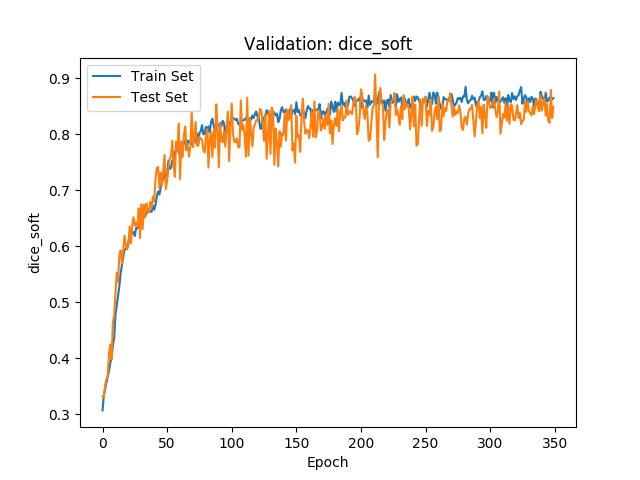

In [3]:
from IPython.display import Image
Image(filename = "evaluation/fold_0/validation.dice_soft.png")

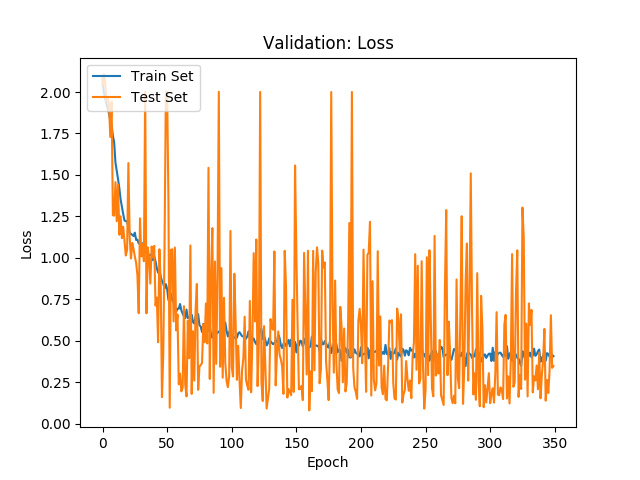

In [4]:
Image(filename = "evaluation/fold_0/validation.loss.png")

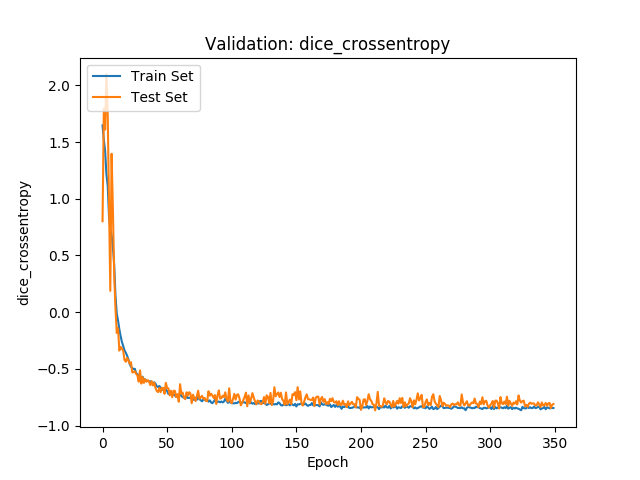

In [5]:
Image(filename = "evaluation/fold_0/validation.dice_crossentropy.png")

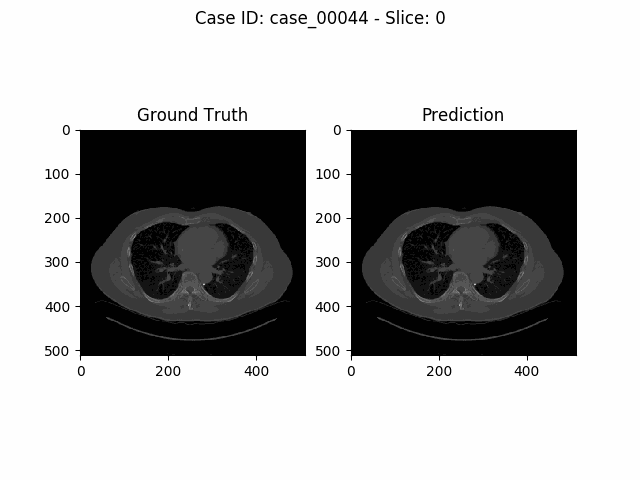

In [7]:
Image(filename = "evaluation/fold_0/visualization.case_case_00044.gif")

## Evaluation results

Looks quite neat. 

But wait, how can we know that this good looking GIF isn't cherry picked?

Let's have a look on the dice scores for all samples in this fold!

In [16]:
import csv
kidney = []
tumor = []
start = True
with open("evaluation/fold_0/detailed_validation.tsv") as tsvfile:
    tsvreader = csv.reader(tsvfile, delimiter="\t")
    for line in tsvreader:
        print(line)
        if start:
            start = False
            continue
        kidney.append(float(line[2]))
        tumor.append(float(line[3]))

['sample_id', 'dice_class-0', 'dice_class-1', 'dice_class-2']
['case_00002', '0.9995979854078331', '0.9382278690280684', '0.7600283343452743']
['case_00051', '0.9995564092394915', '0.9378849954841159', '0.59603490354719']
['case_00035', '0.9998934500057399', '0.9665733311372032', '0.7851029377746935']
['case_00008', '0.999607278235371', '0.8837339488431809', '0.8806957519529541']
['case_00031', '0.9994944105207957', '0.9447786979864732', '0.12993932218440135']
['case_00038', '0.9993912076775896', '0.9585400477960543', '0.8247896627909572']
['case_00025', '0.9993124244137668', '0.9433228862711193', '0.9547118260950712']
['case_00027', '0.9998476022234882', '0.974504516551746', '0.4491084378466001']
['case_00107', '0.9993637913257692', '0.8689577912456158', '0.898406264248609']
['case_00109', '0.9992375145696671', '0.9288534153715242', '0.9134963836787918']
['case_00098', '0.9996684362393842', '0.9652812193698307', '0.8188398849472674']
['case_00016', '0.9997455124607473', '0.96429850308

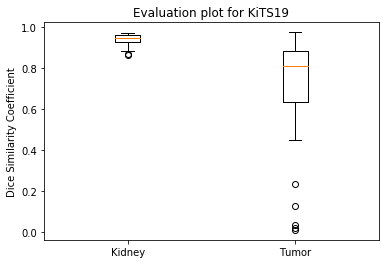

In [29]:
import matplotlib.pyplot as plt
import numpy as np

kidney = np.asarray(kidney) 
tumor = np.asarray(tumor) 

fig, ax = plt.subplots()
ax.set_title('Evaluation plot for KiTS19')
ax.set_ylabel('Dice Similarity Coefficient')
ax.set_xticklabels(["Kidney", "Tumor"])
ax.boxplot([kidney, tumor])
plt.show()

In [30]:
print("Mean Kidney: " + str(np.mean(kidney)))
print("Mean Tumor: " + str(np.mean(tumor)))

print("Median Kidney: " + str(np.median(kidney)))
print("Median Tumor: " + str(np.median(tumor)))

Mean Kidney: 0.9406971871828445
Mean Tumor: 0.7161320936069673
Median Kidney: 0.9471041176551265
Median Tumor: 0.8097638403420089


## Final words

Here, I presented the workflow of using MIScnn for medical image segmentation problems like in this example: The Kidney Tumor Segmentation Challenge 2019.  
I hope to give you an intention on how MIScnn works and how you can integrate/use MIScnn in your research projects.

For further questions or suggestions, please do not hesitate to get in contact with me.

Thanks for reading,  
Dominik Müller